In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import glob
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import os,shutil
from keras import models,layers,optimizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dataset preparation
names = ['commercial','green','no','others', 'parking','residential']
df_train= pd.read_csv(r"/media/ailing/My Passport1/ailing/NTL/MKE/landuse/MKE/Train_labels.csv")
df_train = df_train.replace(0,'commercial').replace(1,'green').replace(2,'no').replace(3,'others').replace(4,'parking').replace(5,'residential')

In [4]:
df_validation= pd.read_csv(r'/media/ailing/My Passport1/ailing/NTL/MKE/landuse/MKE/Validation_labels.csv')
df_validation = df_validation.replace(0,'commercial').replace(1,'green').replace(2,'no').replace(3,'others').replace(4,'parking').replace(5,'residential')

In [5]:
# Data generation
train_datagen = ImageDataGenerator(rescale=1./255,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
#                             reprocessing_function= preprocess_input,
#                            validation_split=0.25
                            )
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                        directory="/media/ailing/My Passport1/ailing/NTL/MKE/landuse/MKE/Train",
                        x_col="image_name",
                        y_col="label",
                        batch_size=20,
#                         seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(300,300))

Found 6169 validated image filenames belonging to 6 classes.


In [6]:
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = validation_datagen.flow_from_dataframe(dataframe=df_validation,
                        directory="/media/ailing/My Passport1/ailing/NTL/MKE/landuse/MKE/Validation",
                        x_col="image_name",
                        y_col="label",
#                         subset="validation", 
                        batch_size=10,
#                         seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(300,300))

Found 2000 validated image filenames belonging to 6 classes.


In [7]:
# Build classification model based on VGG16
from keras.applications.vgg16 import VGG16
vgg_conv = VGG16(include_top = False,
                weights = 'imagenet',
                input_shape = (300,300,3),
                 pooling = None,
                 input_tensor=None
                 )
vgg_conv.trainable = False
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [8]:
model = models.Sequential()
model.add(vgg_conv)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()
model.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(lr=1e-6),metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              42468352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 6150      
Total params: 57,189,190
Trainable params: 42,474,502
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history =model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,verbose=1)

Epoch 1/80
308/308 [==============================] - 285s 924ms/step - loss: 1.9179 - acc: 0.2065 - val_loss: 1.6075 - val_acc: 0.3640
Epoch 2/80
308/308 [==============================] - 110s 359ms/step - loss: 1.7343 - acc: 0.2809 - val_loss: 1.4887 - val_acc: 0.4470
Epoch 3/80
308/308 [==============================] - 120s 389ms/step - loss: 1.6267 - acc: 0.3290 - val_loss: 1.4145 - val_acc: 0.4815
Epoch 4/80
308/308 [==============================] - 125s 405ms/step - loss: 1.5442 - acc: 0.3655 - val_loss: 1.3600 - val_acc: 0.5010
Epoch 5/80
308/308 [==============================] - 120s 390ms/step - loss: 1.4909 - acc: 0.3906 - val_loss: 1.3192 - val_acc: 0.5150
Epoch 6/80
308/308 [==============================] - 123s 398ms/step - loss: 1.4486 - acc: 0.4136 - val_loss: 1.2937 - val_acc: 0.5195
Epoch 7/80
308/308 [==============================] - 123s 398ms/step - loss: 1.4125 - acc: 0.4355 - val_loss: 1.2634 - val_acc: 0.5310
Epoch 8/80
308/308 [============================

Epoch 61/80
308/308 [==============================] - 122s 396ms/step - loss: 1.0794 - acc: 0.5939 - val_loss: 1.0058 - val_acc: 0.6215
Epoch 62/80
308/308 [==============================] - 125s 406ms/step - loss: 1.0777 - acc: 0.5948 - val_loss: 0.9966 - val_acc: 0.6215
Epoch 63/80
308/308 [==============================] - 121s 394ms/step - loss: 1.0867 - acc: 0.5909 - val_loss: 0.9981 - val_acc: 0.6265
Epoch 64/80
308/308 [==============================] - 120s 391ms/step - loss: 1.0732 - acc: 0.5940 - val_loss: 0.9955 - val_acc: 0.6175
Epoch 65/80
308/308 [==============================] - 125s 405ms/step - loss: 1.0755 - acc: 0.5931 - val_loss: 0.9921 - val_acc: 0.6215
Epoch 66/80
308/308 [==============================] - 126s 408ms/step - loss: 1.0753 - acc: 0.5925 - val_loss: 0.9919 - val_acc: 0.6265
Epoch 67/80
308/308 [==============================] - 119s 386ms/step - loss: 1.0749 - acc: 0.5895 - val_loss: 0.9870 - val_acc: 0.6185
Epoch 68/80
308/308 [====================

In [10]:
model.save(r'model_80.h5')

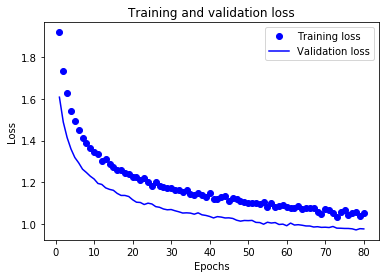

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [4]:
from keras.applications.vgg16 import VGG16
vgg_conv = VGG16(include_top = False,
#                 weights = 'imagenet',
                input_shape = (300,300,3),
                 pooling = None,
                 input_tensor=None
                 )
vgg_conv.trainable = False
model = models.Sequential()
model.add(vgg_conv)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()
model.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(lr=1e-6),metrics=['acc'])
model.load_weights(r'model_80.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              42468352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 6150      
Total params: 57,189,190
Trainable params: 42,474,502
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
names = ['commercial','green','no','others', 'parking','residential']

In [6]:
def predict_image(image_path, names, model,showimage = False,save_path_name = ''):
    im = Image.open(image_path)
    im = im.resize((300,300), Image.ANTIALIAS)
    image_array = np.array(im)/255.0
    im_list = []
    im_list.append(image_array)
    inflow = np.array(im_list)
    cl = model.predict_classes(inflow)
    pro = model.predict_proba(inflow)
    name = names[int(cl)]
    if showimage:
        plt.imshow(im)
        print(pro)
        string = 'Class: ' + name + '.' + 'Probability:' + str(pro[0][cl])
        plt.text(5, 8, string, bbox=dict(facecolor='red', alpha=1))
        if save_path_name != '':
            plt.savefig(save_path_name)
    return cl, pro
def test(image_folder, test_csv, model, names, result_csv):
    new_file = []
    with open(test_csv, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for line in reader:
            if line[0] == 'image_name':
                continue
            else:
                name = line[0]
                image_path = os.path.join(image_folder, name)
                cl, pro = predict_image(image_path, names, model)
                index = cl
                newline = []
                newline.append(name)
                newline.append(line[1])
                newline.append(int(index))
                newline.append(pro[0][int(index)])
                if int(line[1]) == 0 or int(line[1]) == 1:
                    if int(index) == 0:
                        newline.append('True')
                    else:
                        newline.append('False')
                if int(line[1]) == 2:
                    if int(index) == 3:
                        newline.append('True')
                    else:
                        newline.append('False')
                if int(line[1]) == 3:
                    if int(index) == 4:
                        newline.append('True')
                    else:
                        newline.append('False')
                if int(line[1]) == 4:
                    if int(index) == 5:
                        newline.append('True')
                    else:
                        newline.append('False')
                if int(line[1]) == 5 or int(line[1]) == 6:
                    if int(index) == 1:
                        newline.append('True')
                    else:
                        newline.append('False')
                if int(line[1]) == 7:
                    if int(index) == 2:
                        newline.append('True')
                    else:
                        newline.append('False')
                new_file.append(newline)
    with open(result_csv, 'a', newline = '') as csv_file:
        writer = csv.writer(csv_file)
        for line in new_file:
            writer.writerow(line)
def predict_folder(folder_path, output_csv, names,model):
    i = 0
    image_names = os.listdir(folder_path)
    lines = []
    for name in image_names:
        line = []
        image_path = os.path.join(folder_path, name)
        im = Image.open(image_path)
        im = im.resize((300,300), Image.ANTIALIAS)
        
        image_array = np.array(im)/255.0
        im_list = []
        im_list.append(image_array)
        inflow = np.array(im_list)
        cl = model.predict_classes(inflow)
        pro = model.predict_proba(inflow)
        
#         cl,pro = predict_image(image_path,names, model)
        land_type = names[int(cl)]
        line.append(name.split('_')[0])
        line.append(name.split('_')[1])
        line.append(land_type)
        line.append(int(cl))
        line.append(pro[0][int(cl)])
        lines.append(line)
        i = i + 1
        print(i)
    with open(output_csv, 'a', newline='') as csv_file:
        writer = csv.writer(csv_file)
#         writer.writerow(['Object_ID', 'land_type', 'land_code', 'pro'])
        writer.writerow(['x','y', 'land_type', 'land_code', 'pro'])
        for line in lines:
            writer.writerow(line)

[[0.03516349 0.00964302 0.070691   0.01334793 0.0135565  0.8575981 ]]


(array([5]),
 array([[0.03516349, 0.00964302, 0.070691  , 0.01334793, 0.0135565 ,
         0.8575981 ]], dtype=float32))

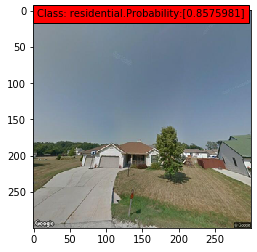

In [8]:
image_path = r'/media/ailing/My Passport1/ailing/NTL/MKE/landuse/MKE/category/residential/42.87349_-87.865665_2.3780890528_0.jpg'
names = ['commercial','green', 'no', 'others', 'parking','residential']
predict_image(image_path, names, model,showimage = True)